In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import gc
import os
import re
import sklearn
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Parallel, delayed
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../src')
sys.path.append(src_dir)

In [3]:
%aimport data.movielens_20m_imdb

from data.movielens_20m_imdb import load_or_get_from_cache

In [4]:
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/movielens-ml20m-imdb/")
ML_ROOT = "/media/felipe/SAMSUNG/movielens/ml-20m/"
IMDB_ROOT = "/media/felipe/SAMSUNG/imdb/"

PATH_TO_MOVIES = ML_ROOT + "/movies.csv"
PATH_TO_TAG_ASSIGNMENTS = ML_ROOT + "/tags.csv"
PATH_TO_MOVIE_PLOTS = IMDB_ROOT+"/plot.list"

In [5]:
docs_df = load_or_get_from_cache(PATH_TO_MOVIES,PATH_TO_TAG_ASSIGNMENTS,PATH_TO_MOVIE_PLOTS,INTERIM_DATA_ROOT)

## number of documents

In [6]:
len(docs_df)

6312

In [7]:
docs_df.head()

,movie_id,title,unique_tags,num_users,num_unique_tags,plot
0,1,Toy Story (1995),"pixar,animation,disney,tom-hanks,computer-anim...",152.0,25,A little boy named Andy loves to be in his roo...
1,2,Jumanji (1995),"robin-williams,fantasy,time-travel,animals,boa...",46.0,25,After being trapped in a jungle board game for...
2,3,Grumpier Old Men (1995),"moldy,old,sequel,old-people-that-is-actually-f...",15.0,15,Things don't seem to change much in Wabasha Co...
3,4,Waiting to Exhale (1995),"chick-flick,characters,revenge,clv",4.0,4,This story based on the best selling novel by ...
4,5,Father of the Bride Part II (1995),"steve-martin,family,wedding,pregnancy,diane-ke...",11.0,16,"In this sequel to ""Father of the Bride"", Georg..."


In [8]:
docs_df.describe()

,movie_id,num_users,num_unique_tags
count,6312.000000,6312.000000,6312.000000
mean,33417.617712,15.161280,11.594265
std,36928.739114,27.283774,8.262508
min,1.000000,2.000000,2.000000
25%,3642.500000,3.000000,4.000000
50%,7927.500000,6.000000,9.000000
75%,62435.250000,15.000000,19.000000
max,130490.000000,561.000000,25.000000


In [9]:
docs_df.describe(include=['object'])

,title,unique_tags,plot
count,6312,6312,6312
unique,6312,6264,6311
top,"Silent Night, Deadly Night (1984)","nudity-topless-notable,nudity-topless",Where the Red Fern Grows is the heartwarming a...
freq,1,5,2


(1, 30)

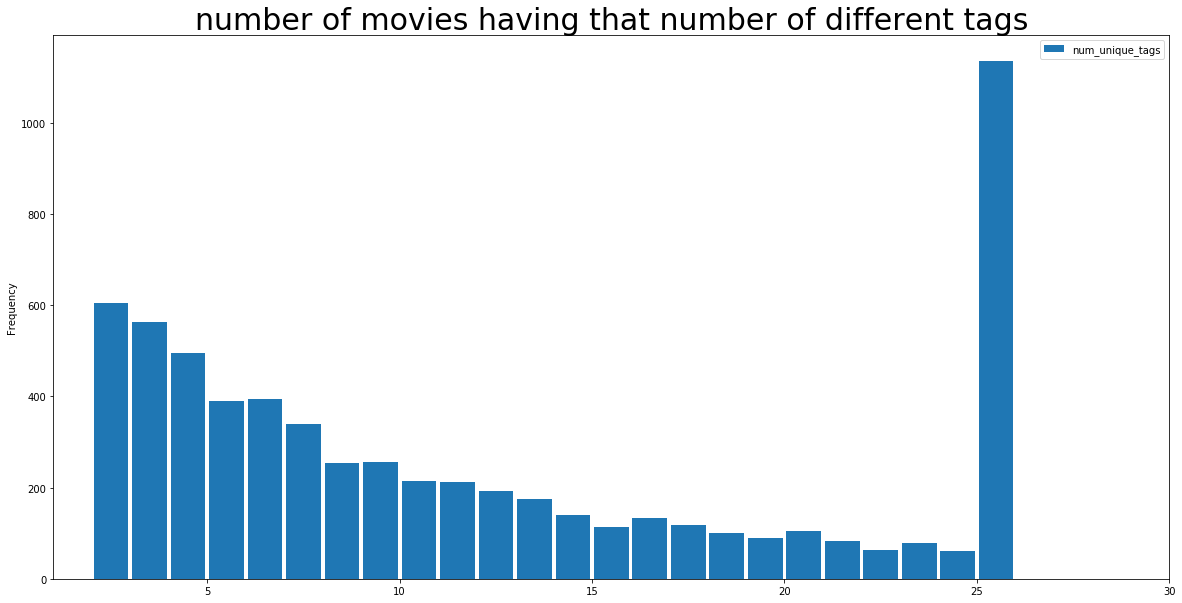

In [10]:
docs_df[['num_unique_tags']].plot(kind='hist',bins=np.arange(1.0,30,1),rwidth=0.9)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of movies having that number of different tags',fontsize=30)
plt.gca().set_xlim(1,30)

## number of unique tags

In [12]:
tagsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

flat_list = []

for tagset in tagsets:
    for tag in tagset:
        flat_list.append(tag)
        
flat_set = set(flat_list)

In [13]:
len(flat_set)

16787

## number of times each tag was given to a movie

(not counting multiple assignments)

In [14]:
labelsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

In [15]:
tag_counts = MultiLabelBinarizer().fit_transform(labelsets).sum(axis=0)

Text(20,6000,'$\\mu=4.36,\\ \\sigma=16.76$')

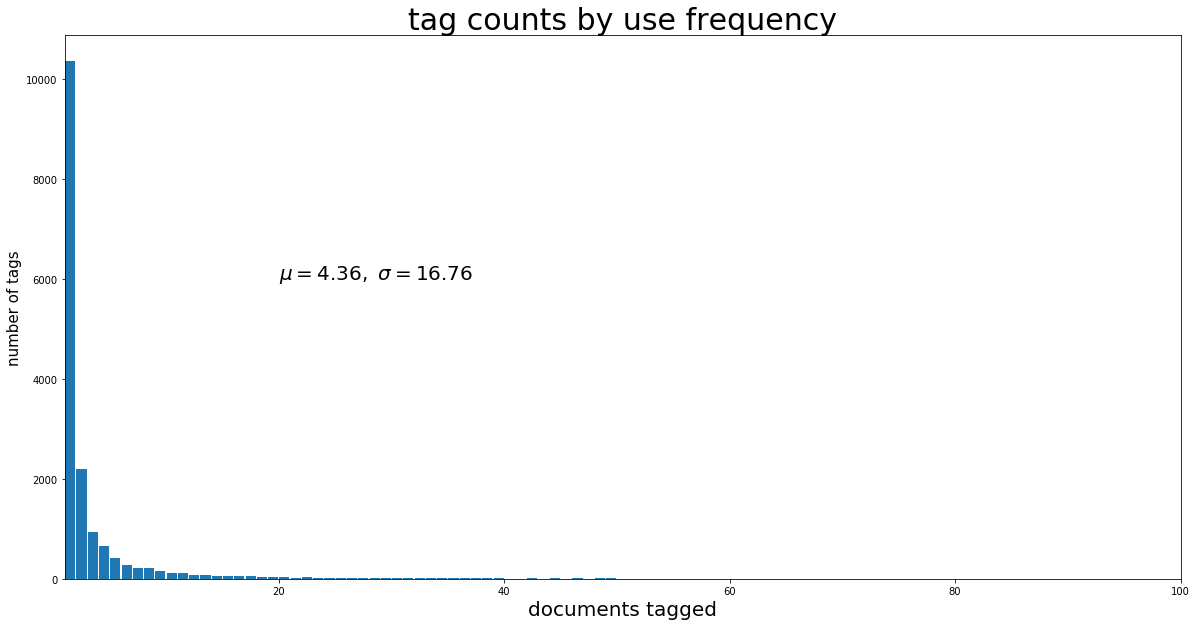

In [16]:
plt.hist(tag_counts,bins=np.arange(1.0,100,1),rwidth=0.9)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('tag counts by use frequency',fontsize=30)
plt.gca().set_xlim(1,100)
plt.xlabel('documents tagged',fontsize=20)
plt.ylabel('number of tags', fontsize=15)
plt.text(20,6000,r'$\mu={0:.2f},\ \sigma={1:.2f}$'.format(tag_counts.mean(), tag_counts.std()), fontsize=20)

In [24]:
docs_df[docs_df['title'].str.lower().str.startswith('harry')]

,movie_id,title,unique_tags,num_users,num_unique_tags,plot
1466,3388,Harry and the Hendersons (1987),"bigfoot,can't-remember,family,william-dear,com...",8.0,10,"Returning from a hunting trip in the forest, t..."
2453,5816,Harry Potter and the Chamber of Secrets (2002),"magic,harry-potter,fantasy,based-on-a-book,ala...",77.0,25,Forced to spend his summer holidays with his m...
3232,8368,Harry Potter and the Prisoner of Azkaban (2004),"magic,harry-potter,time-travel,gary-oldman,bas...",76.0,25,Harry Potter is having a tough time with his r...
3551,26324,Harry and Tonto (1974),"netflix,paul-mazursky,mvlc,bdr,instant-view,mi...",5.0,6,Harry is a retired teacher in his 70s living i...
3994,40815,Harry Potter and the Goblet of Fire (2005),"magic,harry-potter,fantasy,gary-oldman,wizards...",80.0,25,Harry's fourth year at Hogwarts is about to st...
4408,54001,Harry Potter and the Order of the Phoenix (2007),"magic,harry-potter,based-on-a-book,emma-watson...",41.0,25,"After a lonely summer on Privet Drive, Harry r..."
4944,69844,Harry Potter and the Half-Blood Prince (2009),"magic,alan-rickman,fantasy,disappointing,harry...",62.0,25,In the sixth year at Hogwarts School of Witchc...
5135,74948,Harry Brown (2009),"michael-caine,revenge,drugs,emily-mortimer,vig...",11.0,23,"In England, retired Royal Marine Harry Brown s..."
5345,81834,Harry Potter and the Deathly Hallows: Part 1 (...,"magic,based-on-a-book,alan-rickman,british,emm...",60.0,25,Voldemort's power is growing stronger. He now ...
5501,88125,Harry Potter and the Deathly Hallows: Part 2 (...,"magic,fantasy,franchise,daniel-radcliffe,emma-...",37.0,25,"Harry, Ron, and Hermione continue their quest ..."
